In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
df = pd.read_csv('IMDB.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
len(df)

50000

In [5]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df = df[['review', 'sentiment']]

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# Data preprocessing
blanks = []
for i, rv, sn in df.itertuples():
    if type(rv) == str and rv.isspace():
        blanks.append(i)
        
if len(blanks) > 0:
    print(f'There are {len(blanks)} empty space strings in the dataset')
    df.drop(blanks, inplace=True)

In [8]:
df.nunique()

review       49582
sentiment        2
dtype: int64

In [9]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [10]:
max_seq_length = df['review'].str.len().max()

print("Max sequence length:", max_seq_length)

Max sequence length: 13704


In [11]:
words = set(word.lower() for sentence in df['review'] for word in sentence.split())
n_unique_words = len(words)

print("Unique words:", n_unique_words)

Unique words: 390931


In [12]:
X = df['review']
y = df['sentiment']

display(X, y)

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

display(y)

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
# Tokenization
max_len = 150
num_words = 1000

tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(df['review'])

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.3, random_state=101)

X_train_mat = tok.texts_to_sequences(X_train)
X_test_mat = tok.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_mat, maxlen=max_len)
X_test_padded = pad_sequences(X_test_mat, maxlen=max_len)

In [16]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [17]:

# RNN
def create_rnn_model(units, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(SimpleRNN(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

# LSTM
def create_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

# GRU
def create_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(GRU(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

# CNN
def create_cnn_model(filters, kernel_size, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Bidirectional LSTM
def create_bidirectional_lstm_model(units, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Bidirectional GRU
def create_bidirectional_gru_model(units, dropout_rate):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_len))
    model.add(Bidirectional(GRU(units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [18]:
units = 64
dropout_rate = 0.5 

In [19]:
# Initialize models
rnn_model = create_rnn_model(units, dropout_rate)
lstm_model = create_lstm_model(units, dropout_rate)
gru_model = create_gru_model(units, dropout_rate)
cnn_model = create_cnn_model(filters=64, kernel_size=3, dropout_rate=0.5)
bidirectional_lstm_model = create_bidirectional_lstm_model(units, dropout_rate)
bidirectional_gru_model = create_bidirectional_gru_model(units, dropout_rate)

In [20]:
# Compile models
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [22]:
# Train the models and measure time
start_time = time.time()

In [23]:
# RNN
rnn_history = rnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


219/219 [==============================] - 235s 1s/step - loss: 0.5133 - accuracy: 0.7390 - val_loss: 0.4171 - val_accuracy: 0.8181
Epoch 2/10
219/219 [==============================] - 236s 1s/step - loss: 0.4081 - accuracy: 0.8280 - val_loss: 0.3868 - val_accuracy: 0.8370
Epoch 3/10
219/219 [==============================] - 234s 1s/step - loss: 0.3762 - accuracy: 0.8376 - val_loss: 0.3821 - val_accuracy: 0.8364
Epoch 4/10
219/219 [==============================] - 234s 1s/step - loss: 0.3288 - accuracy: 0.8649 - val_loss: 0.4178 - val_accuracy: 0.8320
Epoch 5/10
219/219 [==============================] - 235s 1s/step - loss: 0.2894 - accuracy: 0.8820 - val_loss: 0.3973 - val_accuracy: 0.8317
Epoch 6/10
219/219 [==============================] - 246s 1s/step - loss: 0.2567 - accuracy: 0.8995 - val_loss: 0.4591 - val_accuracy: 0.8049


In [24]:
# LSTM
lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
219/219 [==============================] - 464s 2s/step - loss: 0.4406 - accuracy: 0.7866 - val_loss: 0.3494 - val_accuracy: 0.8504
Epoch 2/10
219/219 [==============================] - 753s 3s/step - loss: 0.3416 - accuracy: 0.8558 - val_loss: 0.3404 - val_accuracy: 0.8524
Epoch 3/10
219/219 [==============================] - 496s 2s/step - loss: 0.3207 - accuracy: 0.8650 - val_loss: 0.3426 - val_accuracy: 0.8521
Epoch 4/10
219/219 [==============================] - 459s 2s/step - loss: 0.3078 - accuracy: 0.8699 - val_loss: 0.3340 - val_accuracy: 0.8579
Epoch 5/10
219/219 [==============================] - 496s 2s/step - loss: 0.2919 - accuracy: 0.8771 - val_loss: 0.3510 - val_accuracy: 0.8531
Epoch 6/10
219/219 [==============================] - 345s 2s/step - loss: 0.2846 - accuracy: 0.8798 - val_loss: 0.3405 - val_accuracy: 0.8544
Epoch 7/10
219/219 [==============================] - 222s 1s/step - loss: 0.2729 - accuracy: 0.8863 - val_loss: 0.3560 - val_accuracy: 0.8521

In [25]:
# GRU
gru_history = gru_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
219/219 [==============================] - 262s 1s/step - loss: 0.4675 - accuracy: 0.7652 - val_loss: 0.3530 - val_accuracy: 0.8464
Epoch 2/10
219/219 [==============================] - 265s 1s/step - loss: 0.3360 - accuracy: 0.8589 - val_loss: 0.3471 - val_accuracy: 0.8511
Epoch 3/10
219/219 [==============================] - 265s 1s/step - loss: 0.3157 - accuracy: 0.8668 - val_loss: 0.3350 - val_accuracy: 0.8549
Epoch 4/10
219/219 [==============================] - 265s 1s/step - loss: 0.2983 - accuracy: 0.8768 - val_loss: 0.3457 - val_accuracy: 0.8539
Epoch 5/10
219/219 [==============================] - 265s 1s/step - loss: 0.2784 - accuracy: 0.8865 - val_loss: 0.3215 - val_accuracy: 0.8636
Epoch 6/10
219/219 [==============================] - 265s 1s/step - loss: 0.2623 - accuracy: 0.8926 - val_loss: 0.3229 - val_accuracy: 0.8691
Epoch 7/10
219/219 [==============================] - 265s 1s/step - loss: 0.2514 - accuracy: 0.8963 - val_loss: 0.3243 - val_accuracy: 0.8576

In [26]:
# CNN
cnn_history = cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Bidirectional LSTM
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

# Bidirectional GRU
bidirectional_gru_history = bidirectional_gru_model.fit(X_train_padded, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
219/219 [==============================] - 27s 124ms/step - loss: 0.5605 - accuracy: 0.7101 - val_loss: 0.4145 - val_accuracy: 0.8143
Epoch 2/10
219/219 [==============================] - 27s 124ms/step - loss: 0.4077 - accuracy: 0.8169 - val_loss: 0.3637 - val_accuracy: 0.8350
Epoch 3/10
219/219 [==============================] - 26s 120ms/step - loss: 0.3591 - accuracy: 0.8426 - val_loss: 0.3430 - val_accuracy: 0.8466
Epoch 4/10
219/219 [==============================] - 28s 127ms/step - loss: 0.3349 - accuracy: 0.8559 - val_loss: 0.3355 - val_accuracy: 0.8514
Epoch 5/10
219/219 [==============================] - 28s 127ms/step - loss: 0.3126 - accuracy: 0.8689 - val_loss: 0.3297 - val_accuracy: 0.8521
Epoch 6/10
219/219 [==============================] - 27s 121ms/step - loss: 0.2933 - accuracy: 0.8799 - val_loss: 0.3265 - val_accuracy: 0.8531
Epoch 7/10
219/219 [==============================] - 27s 122ms/step - loss: 0.2760 - accuracy: 0.8873 - val_loss: 0.3261 - val_ac

In [27]:
end_time = time.time()
training_time = end_time - start_time

In [28]:
# Evaluate models on the test set
rnn_eval = rnn_model.evaluate(X_test_padded, y_test)
lstm_eval = lstm_model.evaluate(X_test_padded, y_test)
gru_eval = gru_model.evaluate(X_test_padded, y_test)
cnn_eval = cnn_model.evaluate(X_test_padded, y_test)
bidirectional_lstm_eval = bidirectional_lstm_model.evaluate(X_test_padded, y_test)
bidirectional_gru_eval = bidirectional_gru_model.evaluate(X_test_padded, y_test)



469/469 [==============================] - 343s 732ms/step - loss: 0.3225 - accuracy: 0.8638


In [29]:
# Extract performance metrics
rnn_test_acc = rnn_eval[1]
lstm_test_acc = lstm_eval[1]
gru_test_acc = gru_eval[1]
cnn_test_acc = cnn_eval[1]
bidirectional_lstm_test_acc = bidirectional_lstm_eval[1]
bidirectional_gru_test_acc = bidirectional_gru_eval[1]


In [30]:
# Print performance metrics and training time
print("RNN Test Accuracy:", rnn_test_acc)
print("LSTM Test Accuracy:", lstm_test_acc)
print("GRU Test Accuracy:", gru_test_acc)
print("CNN Test Accuracy:", cnn_test_acc)
print("Bidirectional LSTM Test Accuracy:", bidirectional_lstm_test_acc)
print("Bidirectional GRU Test Accuracy:", bidirectional_gru_test_acc)
print("Training Time (seconds):", training_time)


RNN Test Accuracy: 0.8340666890144348
LSTM Test Accuracy: 0.8562666773796082
GRU Test Accuracy: 0.8659999966621399
CNN Test Accuracy: 0.8606666922569275
Bidirectional LSTM Test Accuracy: 0.8593999743461609
Bidirectional GRU Test Accuracy: 0.8637999892234802
Training Time (seconds): 17284.91360092163


In [31]:
from sklearn.metrics import classification_report



In [32]:

# Calculate additional metrics (precision, recall, f1 score)
y_pred_rnn = rnn_model.predict(X_test_padded)
y_pred_lstm = lstm_model.predict(X_test_padded)
y_pred_gru = gru_model.predict(X_test_padded)
y_pred_cnn = cnn_model.predict(X_test_padded)
y_pred_bidirectional_lstm = bidirectional_lstm_model.predict(X_test_padded)
y_pred_bidirectional_gru = bidirectional_gru_model.predict(X_test_padded)

y_pred_rnn_binary = (y_pred_rnn > 0.5).astype(int)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)
y_pred_gru_binary = (y_pred_gru > 0.5).astype(int)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)
y_pred_bidirectional_lstm_binary = (y_pred_bidirectional_lstm > 0.5).astype(int)
y_pred_bidirectional_gru_binary = (y_pred_bidirectional_gru > 0.5).astype(int)

# Calculate classification reports
classification_report_rnn = classification_report(y_test, y_pred_rnn_binary)
classification_report_lstm = classification_report(y_test, y_pred_lstm_binary)
classification_report_gru = classification_report(y_test, y_pred_gru_binary)
classification_report_cnn = classification_report(y_test, y_pred_cnn_binary)
classification_report_bidirectional_lstm = classification_report(y_test, y_pred_bidirectional_lstm_binary)
classification_report_bidirectional_gru = classification_report(y_test, y_pred_bidirectional_gru_binary)

# Print classification reports
print("RNN Classification Report:")
print(classification_report_rnn)

print("LSTM Classification Report:")
print(classification_report_lstm)

print("GRU Classification Report:")
print(classification_report_gru)

print("CNN Classification Report:")
print(classification_report_cnn)

print("Bidirectional LSTM Classification Report:")
print(classification_report_bidirectional_lstm)

print("Bidirectional GRU Classification Report:")
print(classification_report_bidirectional_gru)




469/469 [==============================] - 677s 1s/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7474
           1       0.83      0.84      0.83      7526

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7474
           1       0.86      0.85      0.86      7526

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      7474
           1       0.86      0.88      0.87      7526

    accuracy                           0.87 

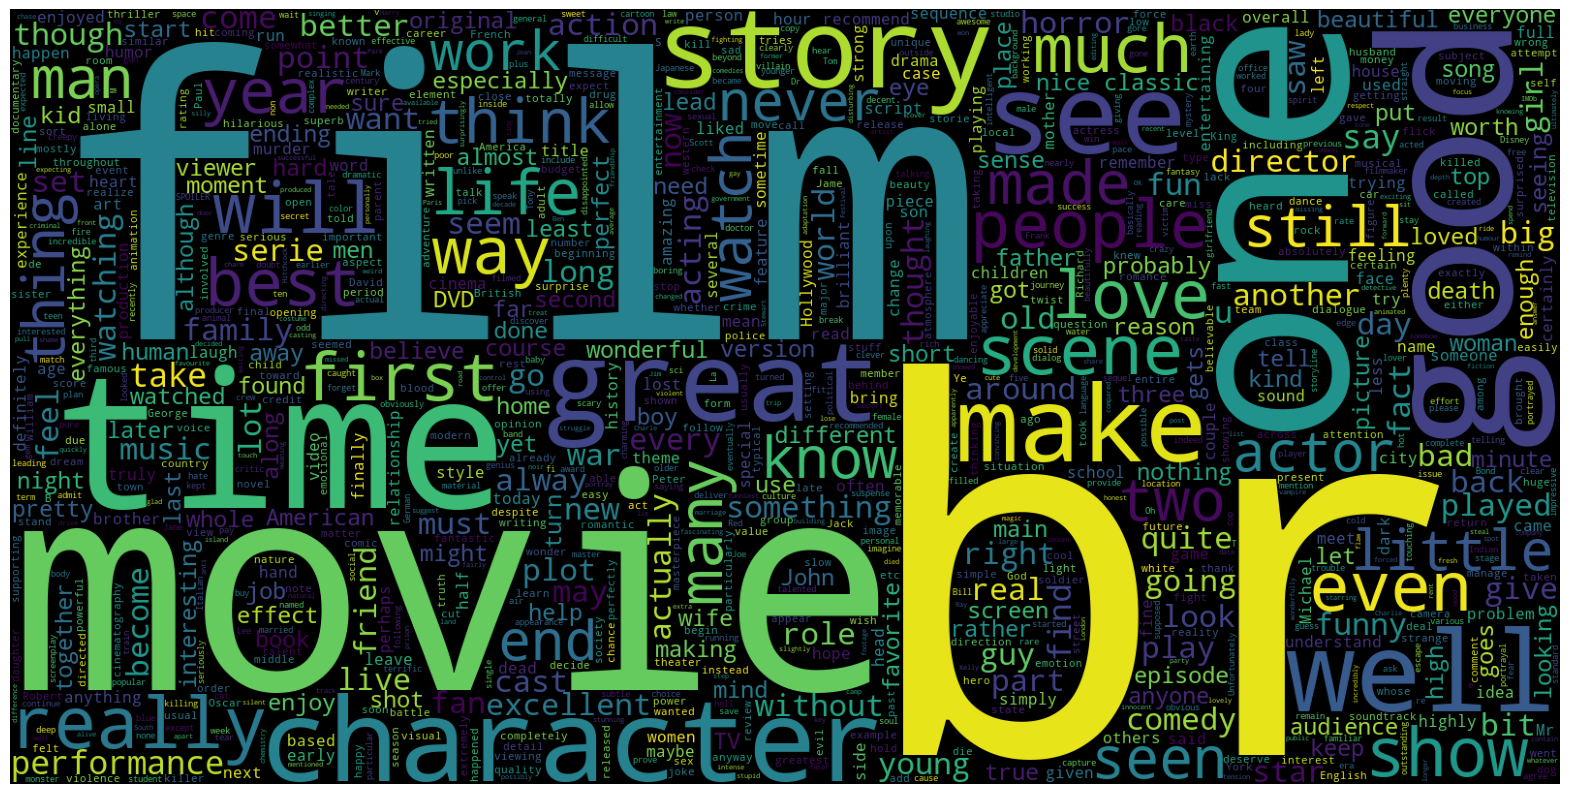

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Generate WordCloud for positive sentiment data
data_pos = df[df['sentiment'] == 'positive']['review']
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_pos))

# Plot WordCloud
plt.figure(figsize=(20, 20))
plt.imshow(wc)
plt.axis("off")
plt.show()



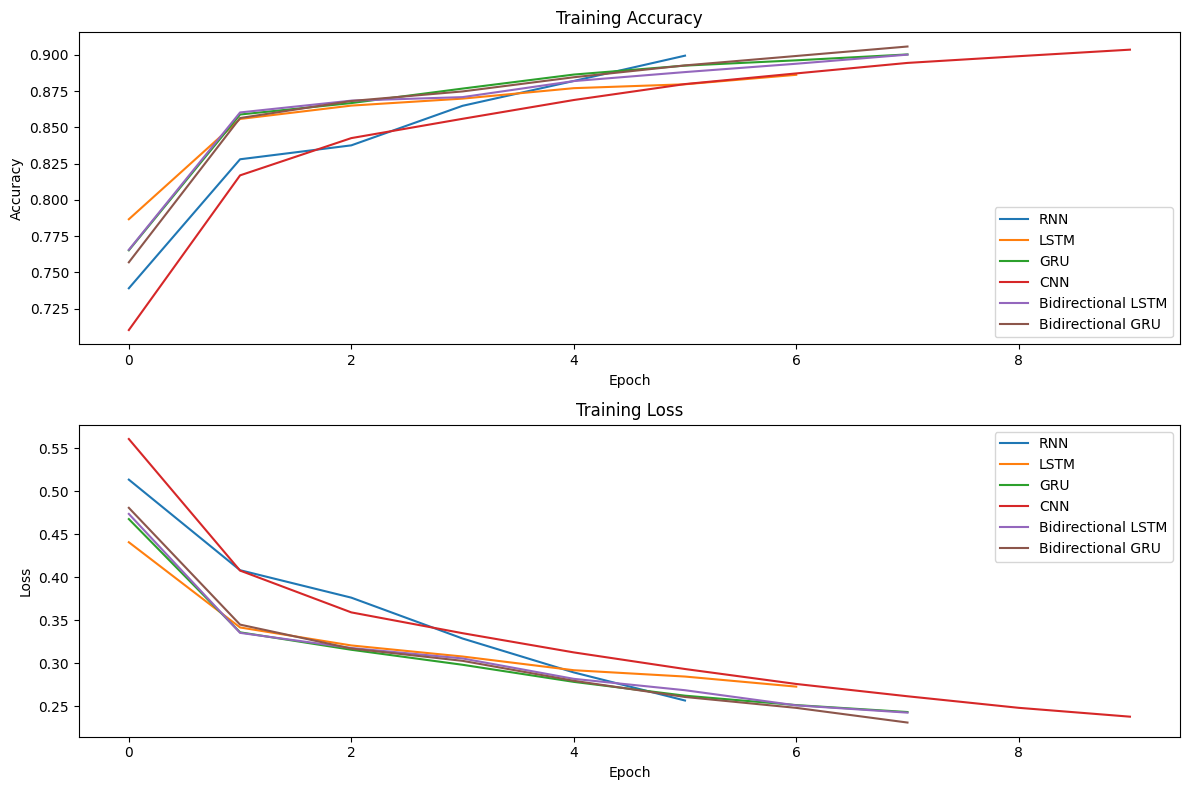

In [38]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 8))

# Training Accuracy
plt.subplot(2, 1, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN')
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(gru_history.history['accuracy'], label='GRU')
plt.plot(cnn_history.history['accuracy'], label='CNN')
plt.plot(bidirectional_lstm_history.history['accuracy'], label='Bidirectional LSTM')
plt.plot(bidirectional_gru_history.history['accuracy'], label='Bidirectional GRU')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(2, 1, 2)
plt.plot(rnn_history.history['loss'], label='RNN')
plt.plot(lstm_history.history['loss'], label='LSTM')
plt.plot(gru_history.history['loss'], label='GRU')
plt.plot(cnn_history.history['loss'], label='CNN')
plt.plot(bidirectional_lstm_history.history['loss'], label='Bidirectional LSTM')
plt.plot(bidirectional_gru_history.history['loss'], label='Bidirectional GRU')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


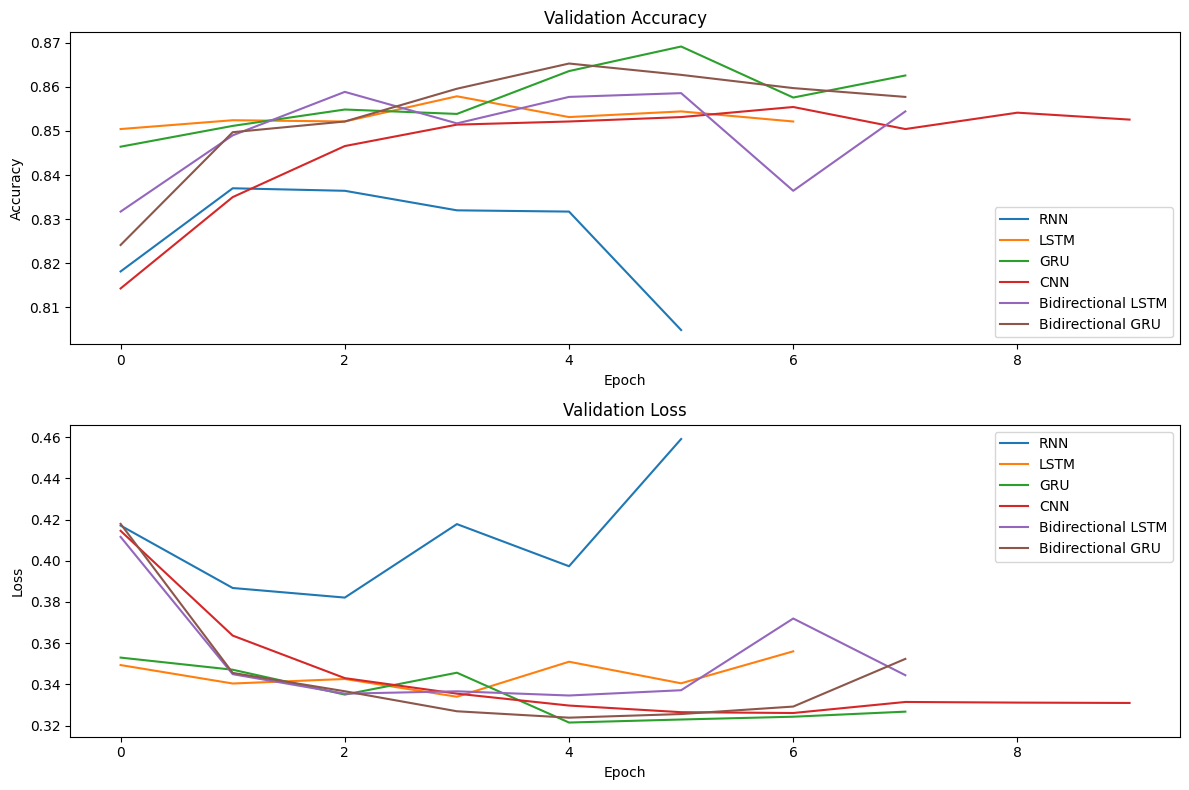

In [39]:
import matplotlib.pyplot as plt

# Plot validation accuracy and validation loss
plt.figure(figsize=(12, 8))

# Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(rnn_history.history['val_accuracy'], label='RNN')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
plt.plot(gru_history.history['val_accuracy'], label='GRU')
plt.plot(cnn_history.history['val_accuracy'], label='CNN')
plt.plot(bidirectional_lstm_history.history['val_accuracy'], label='Bidirectional LSTM')
plt.plot(bidirectional_gru_history.history['val_accuracy'], label='Bidirectional GRU')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Validation Loss
plt.subplot(2, 1, 2)
plt.plot(rnn_history.history['val_loss'], label='RNN')
plt.plot(lstm_history.history['val_loss'], label='LSTM')
plt.plot(gru_history.history['val_loss'], label='GRU')
plt.plot(cnn_history.history['val_loss'], label='CNN')
plt.plot(bidirectional_lstm_history.history['val_loss'], label='Bidirectional LSTM')
plt.plot(bidirectional_gru_history.history['val_loss'], label='Bidirectional GRU')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()